# DTW Evaluation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import ast
import fastdtw
from scipy.spatial.distance import euclidean
from itertools import combinations
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## DTW: The idea behind

In [2]:
def generate_uni_features_ts(lyrics):
    multi_ts = pd.DataFrame(lyrics_statistics(lyrics)).values
    ss = StandardScaler()
    multi_ts = ss.fit_transform(multi_ts)
    pca = PCA(n_components=1, random_state=0)
    uni_ts = np.array([pc[0] for pc in pca.fit_transform(multi_ts)])
    return uni_ts

In [3]:
eg_lyr = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
eg_similar_lyr = pd.read_csv('../data/toy-lyrics/toy_sim.csv', sep='\t')
eg_random_lyr = pd.read_csv('../data/toy-lyrics/toy_rnd.csv', sep='\t')

eg_lyrics = [eg_lyr, eg_similar_lyr, eg_random_lyr]

In [4]:
ts1, ts2, ts3 = [generate_uni_features_ts(list(lyr['lyrics'])) for lyr in eg_lyrics]

ts1_parts, ts2_parts, ts3_parts = [lyr['part'] for lyr in eg_lyrics]

color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(ts1_parts))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

In [5]:
sim_distance, warp_path = fastdtw.dtw(ts1, ts2)
print(f'DTW distance between similar lyrics: {sim_distance}')

rnd_distance = fastdtw.dtw(ts1, ts3)[0]
print(f'DTW distance between random lyrics: {rnd_distance}')

DTW distance between similar lyrics: 24.269195973072804
DTW distance between random lyrics: 37.68821150493047


In [6]:
ts2 = [10 + timestamp for timestamp in ts2] 

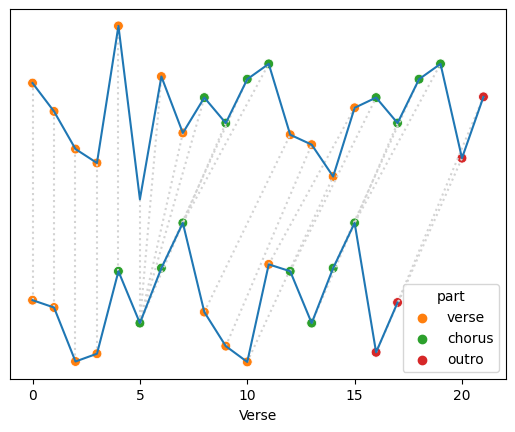

In [7]:
fig, ax = plt.subplots()

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [ts1[map_x], ts2[map_y]], linestyle='dotted', color='lightgray')

sns.lineplot(ts1, color=sns.color_palette()[0]) 
sns.lineplot(ts2, color=sns.color_palette()[0])

sns.scatterplot(y=ts1, x=range(len(ts1)),
                hue=ts1_parts, s=50, palette=color_map)

sns.scatterplot(y=ts2, x=range(len(ts2)),
                hue=ts2_parts, s=50, palette=color_map, legend=False)


ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('Verse')
ax.tick_params(left=False)  # remove the ticks
plt.show()

In [8]:
def evaluate_ts_data(ts_type, normalize=True):
    """
    Evaluate a time series dataset by calculating the similarity scores 
    between the original time series and similar time series, as well as 
    the average distance between the original time series and random time series.

    Parameters
    ----------
    ts_type: str
        The type of time series to be evaluated. This should match the name of the 
        csv file containing the time series data.        
    normalize: bool
        Whether to normalize the data using standard scaler before evaluating the similarity scores. 
    Returns
    -------
    metrics: dict
        A dictionary containing the following keys: 
        - 'similarity_score': float, representing the ratio of time series pairs where 
                              the distance between the original time series and the 
                              similar time series is less than the distance between 
                              the original time series and the random time series.
        
        - 'avg_sim_distance': float, representing the average DTW distance between 
                              the original time series and the similar time series.
        
        - 'avg_rnd_distance': float, representing the average DTW distance between the 
                              original time series and the random time series.
    """
    ts_data = pd.read_csv(f'../data/evaluation/time-series/{ts_type}.csv')
    for column in ts_data.columns:
        ts_data[column] = list(
            map(lambda x: np.array(ast.literal_eval(x)), ts_data[column]))
    if normalize:
        scaler = StandardScaler()            
        for column in ts_data.columns:
            ts_data[column] = list(
                map(lambda x: scaler.fit_transform(x.reshape(-1, 1)), ts_data[column]))    
    sim_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['similar_lyrics'])]
    rnd_dtw = [fastdtw.dtw(ts1, ts2)[0] for ts1, ts2 in zip(ts_data['lyrics'], ts_data['random_lyrics'])]
    sim_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if similar < random)
    rnd_closer = sum(1 for similar, random in zip(sim_dtw, rnd_dtw) if random < similar)
    similarity_score = sim_closer / (sim_closer + rnd_closer)        
    avg_sim_dtw = np.mean(sim_dtw)
    avg_rnd_dtw = np.mean(rnd_dtw)    
    metrics = {'type': ts_type,
               'similarity_score': similarity_score, 
               'avg_sim_distance': avg_sim_dtw, 
               'avg_rnd_distance': avg_rnd_dtw}
    return metrics

# Features Time Series

In [13]:
ts_types = ['features_avg_ts', 'features_max_ts', 'features_pca_ts', 'features_gpca_ts']

for ts_type in ts_types:
    print(evaluate_ts_data(ts_type, normalize=True))

{'type': 'features_avg_ts', 'similarity_score': 0.95, 'avg_sim_distance': 28.425394942864397, 'avg_rnd_distance': 42.966819388363376}
{'type': 'features_max_ts', 'similarity_score': 0.63, 'avg_sim_distance': 35.22864342673013, 'avg_rnd_distance': 41.449385179011415}
{'type': 'features_pca_ts', 'similarity_score': 0.86, 'avg_sim_distance': 25.187406641829707, 'avg_rnd_distance': 42.24415471191067}
{'type': 'features_gpca_ts', 'similarity_score': 1.0, 'avg_sim_distance': 15.841435502701747, 'avg_rnd_distance': 42.24031507362676}


## Sentence BERT Time Series

In [10]:
ts_types = ['sbert_avg_ts', 'sbert_max_ts', 'sbert_pca_ts', 'sbert_gpca_ts']

for ts_type in ts_types:
    print(evaluate_ts_data(ts_type, normalize=True))

{'type': 'sbert_avg_ts', 'similarity_score': 0.68, 'avg_sim_distance': 34.53823255837192, 'avg_rnd_distance': 42.90772155483576}
{'type': 'sbert_max_ts', 'similarity_score': 0.67, 'avg_sim_distance': 34.7667776188836, 'avg_rnd_distance': 41.85793409322508}
{'type': 'sbert_pca_ts', 'similarity_score': 0.66, 'avg_sim_distance': 33.76954688842068, 'avg_rnd_distance': 41.25883783115209}
{'type': 'sbert_gpca_ts', 'similarity_score': 0.8, 'avg_sim_distance': 32.50302027733616, 'avg_rnd_distance': 42.475359136420195}


## Doc2Vec Time Series

In [12]:
ts_types = ['d2v_avg_ts', 'd2v_max_ts', 'd2v_pca_ts', 'd2v_gpca_ts']

for ts_type in ts_types:
    print(evaluate_ts_data(ts_type, normalize=True))

{'type': 'd2v_avg_ts', 'similarity_score': 0.58, 'avg_sim_distance': 35.997493282312135, 'avg_rnd_distance': 41.55438544956863}
{'type': 'd2v_max_ts', 'similarity_score': 0.63, 'avg_sim_distance': 35.11885317119583, 'avg_rnd_distance': 40.62185506466123}
{'type': 'd2v_pca_ts', 'similarity_score': 0.52, 'avg_sim_distance': 37.7290412454701, 'avg_rnd_distance': 41.95910333902785}
{'type': 'd2v_gpca_ts', 'similarity_score': 0.6, 'avg_sim_distance': 35.545285478302844, 'avg_rnd_distance': 41.94583862044939}


## Emotion Time Series

In [14]:
ts_types = ['emotion_ts', 'sentiment_ts']


for ts_type in ts_types:
    print(evaluate_ts_data(ts_type, normalize=True))

{'type': 'emotion_ts', 'similarity_score': 0.74, 'avg_sim_distance': 32.67682218202745, 'avg_rnd_distance': 42.115595254827085}
{'type': 'sentiment_ts', 'similarity_score': 0.85, 'avg_sim_distance': 27.692329272270502, 'avg_rnd_distance': 41.4430333379779}
